# Using An Ultrasound Transducer As A Sensor Example

This example shows how an ultrasound transducer can be used as a detector by substituting a transducer object for the normal sensor input structure. It builds on the Defining An Ultrasound Transducer and Simulating Ultrasound Beam Patterns examples.


### Notes

The example is based on the original kWave example in Matlab. A few parts were adapted to make it compatible with `k-wave-python`.

In [1]:
import os
from copy import deepcopy
from tempfile import gettempdir
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.utils.mapgen import make_disc, make_cart_circle
from kwave.utils.colormap import get_color_map

In [2]:
# create the computational grid and propagation medium
grid_size = Vector([128, 128])  # [grid points]
grid_spacing = Vector([0.1e-3, 0.1e-3])  # [m]
kgrid = kWaveGrid(grid_size, grid_spacing)

medium = kWaveMedium(sound_speed=1500)

In [3]:
# create initial pressure distribution using make_disc
disc_magnitude = 5 # [Pa]
disc_pos = Vector([50, 50])  # [grid points]
disc_radius = 8    # [grid points]
disc_1 = disc_magnitude * make_disc(grid_size, disc_pos, disc_radius)

disc_magnitude = 3 # [Pa]
disc_pos = Vector([80, 60])  # [grid points]
disc_radius = 5    # [grid points]
disc_2 = disc_magnitude * make_disc(grid_size, disc_pos, disc_radius)

source = kSource()
source.p0 = disc_1 + disc_2

In [4]:
# define a centered circular sensor
sensor_radius = 4e-3   # [m]
num_sensor_points = 50
sensor_mask = make_cart_circle(sensor_radius, num_sensor_points)
sensor = kSensor(sensor_mask)

In [5]:
# Define a function to run simulation with given options
def run_simulation_with_options(**simulation_opts) -> Dict[str, np.array]:
    simulation_options = SimulationOptions(
        save_to_disk=True,
        **simulation_opts
    )
    execution_options = SimulationExecutionOptions(is_gpu_simulation=False)
    
    sensor_data = kspaceFirstOrder2DC(
        medium=medium,
        kgrid=kgrid,
        source=deepcopy(source),
        sensor=deepcopy(sensor),
        simulation_options=simulation_options,
        execution_options=execution_options
    )
    return sensor_data

In [6]:
# Update the example ID below to change the simulation conditions
example_idx = 1

if example_idx == 1:
    options = {'pml_alpha': 0}
elif example_idx == 2:
    options = {'pml_alpha': 1e6}
elif example_idx == 3:
    options = {'pml_size': 2}
elif example_idx == 4:
    options = {'pml_inside': False}
else:
    raise NotImplementedError()

sensor_data = run_simulation_with_options(**options)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                      2 │
│ Processor name:      Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────��───────────────────────────────────────────┤
│ Domain dimensions:                                  128 x 128 │
│ Medium type:                                               2D │
│ Simulation time steps:                                    604 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory 

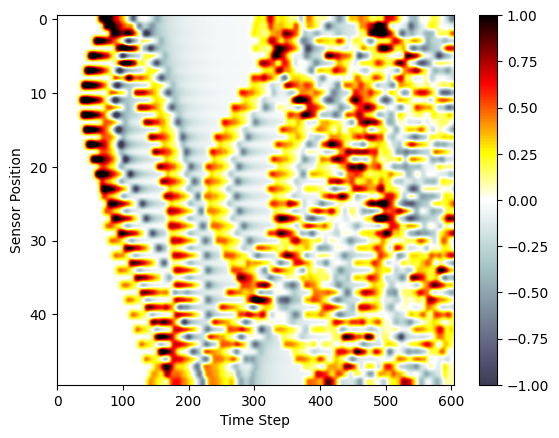

In [8]:
plt.imshow(sensor_data['p'].T, cmap=get_color_map(), vmin=-1, vmax=1, aspect='auto')
plt.ylabel('Sensor Position')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

### Comparing against Matlab implementation

Seems like above example runs successfully but ... How do we know if our results match the Matlab implementation? A simple yet effective strategy is to run Matlab script, record outputs, load them in Python and compare the results. Huh, sounds involved and it is indeed a bit involved. However, we did it and you can do this in two steps:
1. Open Matlab and run `modified_matlab_example.m` script in this folder.
2. Execute the cell below.

Step #1 will run the Matlab example and record values. Step #2 will load values and compare `k-wave-python` outputs against Matlab implementation.

You may be wondering at this point, why we do not run `example_na_controlling_the_pml.m` (original Matlab script) instead of the script from this folder. There are two reasons - (1) original example does not record output values in a file and (2) it runs one simulation case at a time. Modified example records output values (recorded pressure and visualized image) and runs all four simulation cases. In case you want to run the original example by adding output recording logic and running all four simulation cases individually, please feel free to do so. If everything is correct, you will get the same results as the `modified_matlab_example.m`.

In [9]:
from scipy.io import loadmat

matlab_output_path = f'example_{example_idx}.mat'

if not os.path.exists(matlab_output_path):
    print("Data recorded from Matlab script does not exist! Did you run the `modified_matlab_example.m` in Matlab?")
else:
    recorded_data = loadmat(matlab_output_path, simplify_cells=True)
    assert np.allclose(recorded_data['sensor_data'].T, sensor_data['p'])